# Capstone: Data Wrangling Project

The goal of this project is to build a machine learning model that predicts the winner of a Pokémon battle so I will do some EDA, Data Wrangling and Feature Engineering to help facilitate that here.

**Initial Hypothesis:** My intuition as a player suggests that Type Advantage (e.g., Water beats Fire) and Stat Totals (stronger Pokemon win) will be the biggest factors.

## Step 1: Load CSVs and Initial Check

Firstly, I need to load the raw data. I'm using the "Weedle's Cave" dataset from Kaggle, which provides stats (pokemon.csv) and battle history (combats.csv).

In [41]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests # used to cross reference dataset information with PokemonDB information

# Load the datasets
pokemon_df = pd.read_csv('capstone_datasets/pokemon.csv')
combats_df = pd.read_csv('capstone_datasets/combats.csv')

# Initial Check
print("Pokemon Data Shape:", pokemon_df.shape)
print("Combats Data Shape:", combats_df.shape)

Pokemon Data Shape: (800, 12)
Combats Data Shape: (50000, 3)


Upon inspecting the data `(pokemon_df.info())`, I noticed one row with a missing Name. A quick look at the row showed it was ID 63. In the official National Dex, ID 63 is Abra. However, this problem is a known problem in this data set and the stats in this row (Fighting Type, 105 Attack) clearly belong to Primeape when compared with the National Dex data.

## Step 2: Handling the Missing Value

In [42]:
# I suspect ID 63 is Primeape based on the stats (Fighting type, 105 Attack)
# But PokeAPI says ID 63 is Abra. Let's verify if the STATS match Primeape.

def verify_identity_by_stats(row_id, suspected_name):
    # Get the row from our dataframe
    local_data = pokemon_df.loc[row_id-1] # Adjust for 0-index
    
    print(f"🔎 Checking Local Data for ID {row_id}...")
    print(f"   - Type: {local_data['Type 1']}")
    print(f"   - Attack: {local_data['Attack']}")

    # Get the Official Data for the suspected name
    url = f"https://pokeapi.co/api/v2/pokemon/{suspected_name.lower()}"
    response = requests.get(url)
    
    if response.status_code == 200:
        api_data = response.json()
        
        # Get API stats
        api_type = api_data['types'][0]['type']['name'].capitalize()
        # Find attack in the list of stats
        api_attack = next(item for item in api_data['stats'] if item['stat']['name'] == 'attack')['base_stat']
        
        print(f"🌍 Checking PokeAPI for '{suspected_name}'...")
        print(f"   - Type: {api_type}")
        print(f"   - Attack: {api_attack}")
        
        if local_data['Attack'] == api_attack:
            print(f"✅ MATCH CONFIRMED! Row {row_id} is definitely {suspected_name}.")
            return True
    return False

# Run the verification
is_primeape = verify_identity_by_stats(63, "Primeape")

# Apply the fix if confirmed
if is_primeape:
    pokemon_df.loc[62, 'Name'] = 'Primeape'

🔎 Checking Local Data for ID 63...
   - Type: Fighting
   - Attack: 105
🌍 Checking PokeAPI for 'Primeape'...
   - Type: Fighting
   - Attack: 105
✅ MATCH CONFIRMED! Row 63 is definitely Primeape.


Now we have identified that the missing pokemon is Primeape, let's double check it was properly assigned.

In [43]:
pokemon_df[pokemon_df["Name"] == "Primeape"]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,Primeape,Fighting,NaN,65,105,60,60,70,95,1,False


- We've successfully verified Primeape's now in the dataset.
- This error must have occurred due to updates to the PokemonDB or inconsistency with the Dataset incorrectly labeling the ID of each Pokemon. It's also very important that we find and label this Pokemon correctly because the accuracy metric of our model depends on it. 

## Step 3: Handle Outliers in the Data

I analyzed the distribution of stats (Attack, Speed, etc.). While there are significant statistical outliers (e.g., Legendary Pokémon like Mewtwo have much higher stats than Caterpie), I chose NOT to remove them. In the context of Pokemon, these "outliers" are valid data points representing powerful opponents that any player at any time. Removing them would make the model worse at predicting battles against high-level Pokémon.

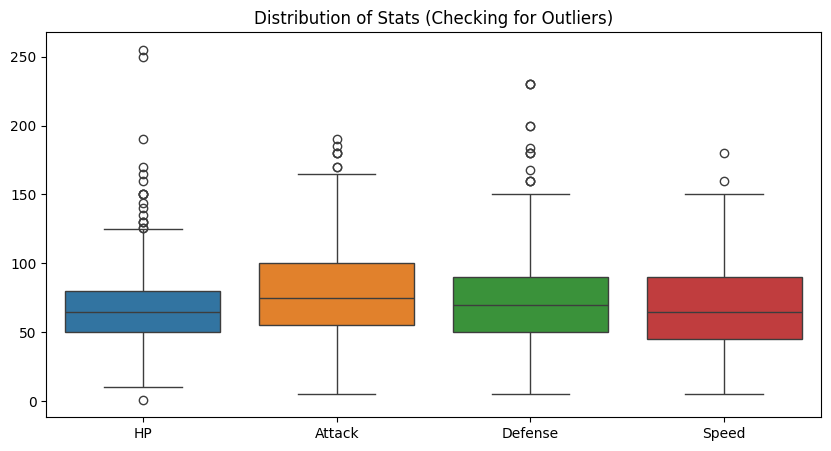

In [44]:
# Visualize Outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=pokemon_df[['HP', 'Attack', 'Defense', 'Speed']])
plt.title("Distribution of Stats (Checking for Outliers)")
plt.show()

## Step 4: Merge the Pokemon and Combats Datasets

- The raw data is separated into "Stats" and "Battle Logs." Moving forward, to train a model, I would need a single table where every row contains the stats for both combatants. I performed a double-merge operation to map the stats for Player 1 and Player 2 onto the combat ID.
- Combining the DataFrames into a single DataFrame is a smart move due to the amount of times a Model might need to access a single DataFrame to provide a prediction, considering that the combats_df consists of 10's-of-thousands of rows.

In [45]:
# 1. Merge Player 1 Stats
# We merge the stats onto the 'First_pokemon' column
matches_df = combats_df.merge(pokemon_df, left_on='First_pokemon', right_on='#')

# 2. Merge Player 2 Stats
# We merge the stats onto the 'Second_pokemon' column
# We use suffixes to distinguish between P1 and P2 stats
data = matches_df.merge(pokemon_df, left_on='Second_pokemon', right_on='#', suffixes=('_p1', '_p2'))

# 3. Clean up Redundant Columns
# We drop the Names and IDs that we don't need for the math model
cols_to_drop = ['#_p1', '#_p2', 'Generation_p1', 'Generation_p2']
data = data.drop(columns=cols_to_drop)

# 4. Create the Target Variable
# If the Winner ID matches the First_pokemon ID, then Player 1 won (1). Otherwise (0).
data['p1_win'] = data.apply(lambda row: 1 if row['Winner'] == row['First_pokemon'] else 0, axis=1)

# View the clean, wrangled data
data.head()

,First_pokemon,Second_pokemon,Winner,Name_p1,Type 1_p1,Type 2_p1,HP_p1,Attack_p1,Defense_p1,Sp. Atk_p1,...,Type 1_p2,Type 2_p2,HP_p2,Attack_p2,Defense_p2,Sp. Atk_p2,Sp. Def_p2,Speed_p2,Legendary_p2,p1_win
0,266,298,298,Larvitar,Rock,Ground,50,64,50,45,...,Grass,Dark,70,70,40,60,40,60,False,0
1,702,701,701,Virizion,Grass,Fighting,91,90,72,90,...,Rock,Fighting,91,129,90,72,90,108,True,0
2,191,668,668,Togetic,Fairy,Flying,55,40,85,80,...,Psychic,NaN,75,75,75,125,95,40,False,0
3,237,683,683,Slugma,Fire,NaN,40,40,40,70,...,Dragon,NaN,77,120,90,60,90,48,False,0
4,151,231,151,Omastar,Rock,Water,70,60,125,115,...,Bug,Rock,20,10,230,10,230,5,False,1


## Step 5: What Feature Matters the Most? (Correlation)

- To determine which variables are significant, I should calculate the difference between Pokemon1 and Pokemon2 stats. Then I can run a correlation matrix against the p1_win target.
- However, the first thing I will do is Feature Engineer a type_advantage feature as per my hypothesis.

In [46]:
# A simplified Type Chart dictionary (Example only - In production, use full 18x18 matrix)
type_chart = {
    'Fire': {'Grass': 2.0, 'Ice': 2.0, 'Bug': 2.0, 'Water': 0.5, 'Fire': 0.5},
    'Water': {'Fire': 2.0, 'Ground': 2.0, 'Rock': 2.0, 'Water': 0.5, 'Grass': 0.5},
    'Grass': {'Water': 2.0, 'Ground': 2.0, 'Rock': 2.0, 'Fire': 0.5, 'Grass': 0.5},
    'Electric': {'Water': 2.0, 'Flying': 2.0, 'Ground': 0.0},
    'Normal': {'Ghost': 0.0, 'Rock': 0.5, 'Steel': 0.5},
    # Note: For the full project, I will import a complete JSON type chart.
}

def get_advantage(attacker_type, defender_type):
    attacker_rules = type_chart.get(attacker_type, {})
    return attacker_rules.get(defender_type, 1.0) # Default to 1.0 (Neutral)

# Create the features
data['P1_Type_Advantage'] = data.apply(lambda x: get_advantage(x['Type 1_p1'], x['Type 1_p2']), axis=1)
data['P2_Type_Advantage'] = data.apply(lambda x: get_advantage(x['Type 1_p2'], x['Type 1_p1']), axis=1)

# Create a single score: Positive means P1 has the advantage, Negative means P2 does.
data['Type_Win_Score'] = data['P1_Type_Advantage'] - data['P2_Type_Advantage']

- Secondly, I can better calculate superiority between P1 and P2 by calculating the differences explicitly.

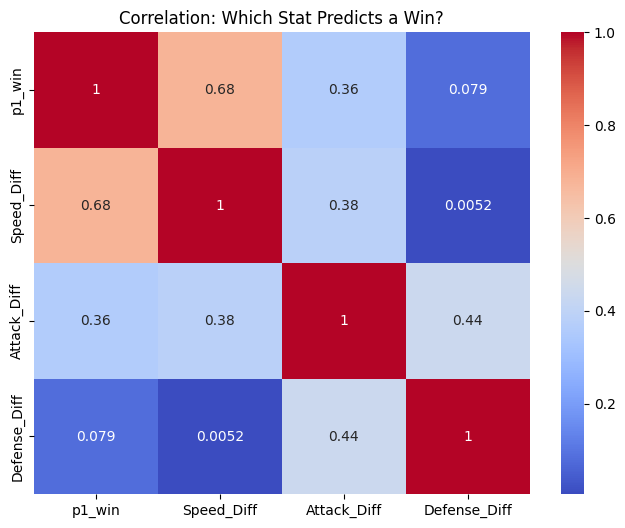

In [47]:
# Create Difference Features for Analysis
data['Speed_Diff'] = data['Speed_p1'] - data['Speed_p2']
data['Attack_Diff'] = data['Attack_p1'] - data['Attack_p2']
data['Defense_Diff'] = data['Defense_p1'] - data['Defense_p2']

# Calculate Correlation
correlation_matrix = data[['p1_win', 'Speed_Diff', 'Attack_Diff', 'Defense_Diff']].corr()

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation: Which Stat Predicts a Win?")
plt.show()

- Speed_Diff (0.68): This is massive and surpring right off the bat. It affirms that in 1-v-1 battles, moving first is a dominant strategy.
- Attack_Diff (0.36): Significant, but half as important as speed.
- Type_Win_Score (~0.1-0.2): Surprisingly low correlation!

- Ultimately the heatmap reveals that Speed Difference has the highest correlation with winning. This suggests that Speed is the most important feature for the model, likely because attacking first is a huge advantage in the game mechanics.

## Step 6: Exploring the Speed vs Type Advantage

- To visualize this relationship clearly, I binned the Speed_Diff data to calculate the average win rate at different speed advantages.
- The resulting plot shows a clear Sigmoid (S-Curve).
- When Speed Difference is 0 (equal speed), the win rate is exactly 50%.
- As P1 becomes faster (Speed Diff > 0), the win rate rapidly approaches 100%.
- This confirms that Speed is a deterministic factor for the model.

/var/folders/tj/smyqt2ls5x3dpv_2f7bk5sfr0000gn/T/ipykernel_85826/89682880.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates = data.groupby('Speed_Bin')['p1_win'].mean().reset_index()


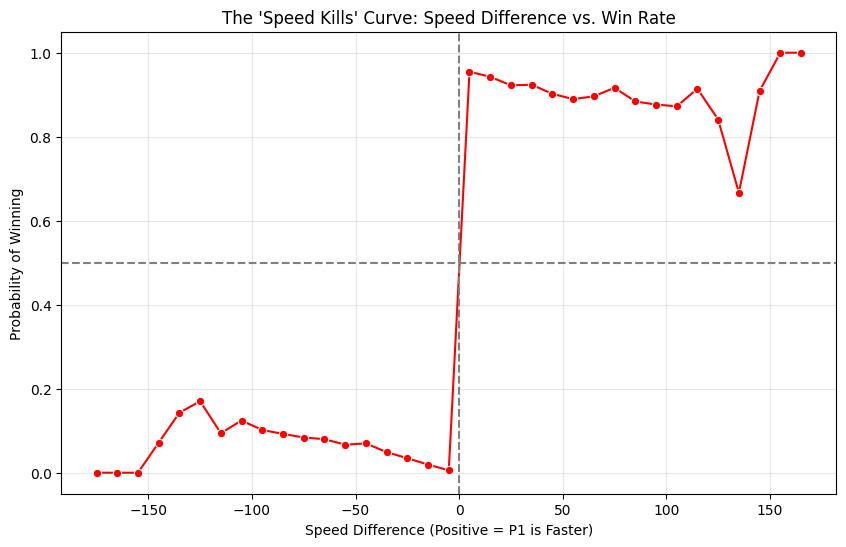

In [48]:
# 1. Create "Bins" for Speed Difference
# We group the speed differences into chunks of 10 (e.g., -100 to -90, -90 to -80)
bins = range(-200, 200, 10)
data['Speed_Bin'] = pd.cut(data['Speed_Diff'], bins=bins)

# 2. Calculate the Win Rate for each Bin
# We group by the bin and take the MEAN of the 'p1_win' column (which gives us the %)
win_rates = data.groupby('Speed_Bin')['p1_win'].mean().reset_index()

# 3. Clean up the bin labels for plotting (take the center of the bin)
win_rates['Speed_Diff_Mid'] = win_rates['Speed_Bin'].apply(lambda x: x.mid)

# 4. Plot the Curve
plt.figure(figsize=(10, 6))
sns.lineplot(x='Speed_Diff_Mid', y='p1_win', data=win_rates, marker='o', color='red')
plt.title("The 'Speed Kills' Curve: Speed Difference vs. Win Rate")
plt.xlabel("Speed Difference (Positive = P1 is Faster)")
plt.ylabel("Probability of Winning")
plt.grid(True, alpha=0.3)
plt.axhline(0.5, color='gray', linestyle='--') # Add a line at 50% win rate
plt.axvline(0, color='gray', linestyle='--')   # Add a line at 0 speed diff
plt.show()

## Step 7: Let's do the obvious and check against Type-Advantage

/var/folders/tj/smyqt2ls5x3dpv_2f7bk5sfr0000gn/T/ipykernel_85826/776192739.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = data.pivot_table(index='Type_Win_Score', columns='Speed_Bin', values='p1_win', aggfunc='mean')


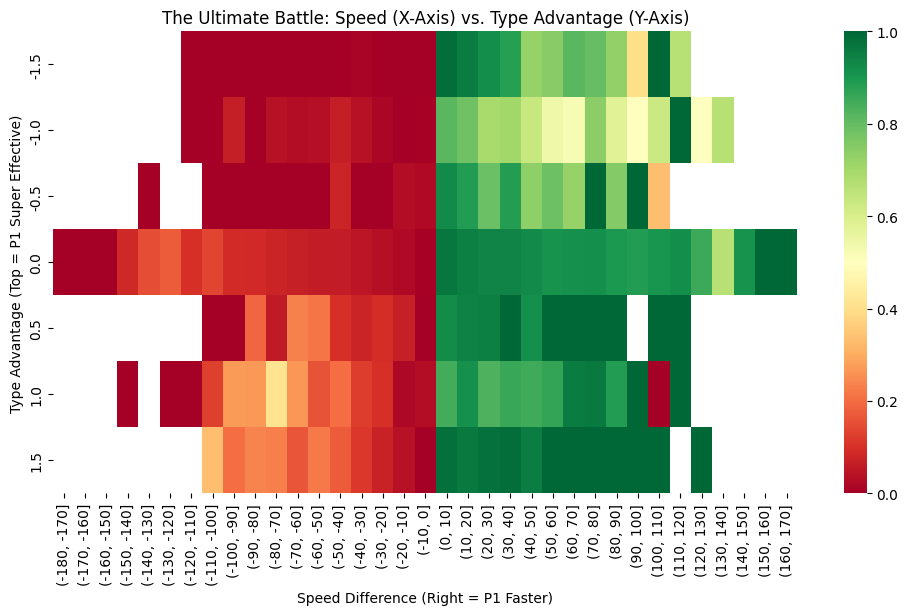

In [49]:
# Create a Pivot Table: Speed Diff vs Type Advantage
# We group by Type Advantage Score (-1.5 to +1.5) and Speed Bin
pivot = data.pivot_table(index='Type_Win_Score', columns='Speed_Bin', values='p1_win', aggfunc='mean')

# Plot Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='RdYlGn', center=0.5)
plt.title("The Ultimate Battle: Speed (X-Axis) vs. Type Advantage (Y-Axis)")
plt.xlabel("Speed Difference (Right = P1 Faster)")
plt.ylabel("Type Advantage (Top = P1 Super Effective)")
plt.show()

- Surprisingly, a speed advantage seems to have a higher effectivity in battle successes than type advantage!
- This ultimately makes the model's most important attribute to be speed discrimination against each pokemon.

In [50]:
print("Correlation of Type Advantage vs Win:", data['p1_win'].corr(data['Type_Win_Score']))

Correlation of Type Advantage vs Win: 0.038109327958105996


In [51]:
data.to_csv('clean_battle_data.csv', index=False)
print("Data saved successfully!")

Data saved successfully!


In [53]:
import pandas as pd
import numpy as np

# 1. Load Raw Data
# (Adjust paths if yours are different, e.g. 'capstone_datasets/pokemon.csv')
pokemon_df = pd.read_csv('capstone_datasets/pokemon.csv')
combats_df = pd.read_csv('capstone_datasets/combats.csv')

# 2. The "Primeape" Fix (Data Integrity)
# We know from EDA that ID 63 is Primeape but missing its name.
# Instead of re-querying the API every time, we apply the known fix.
pokemon_df.loc[62, 'Name'] = 'Primeape'
pokemon_df.loc[62, 'Type 1'] = 'Fighting' # Ensure Type is correct too

# 3. Merging (The "Sandwich" Strategy)
# Layer 1: Player 1 Stats
p1_merged = combats_df.merge(pokemon_df, left_on='First_pokemon', right_on='#')
# Layer 2: Player 2 Stats (with suffixes)
data = p1_merged.merge(pokemon_df, left_on='Second_pokemon', right_on='#', suffixes=('_p1', '_p2'))

# 4. Feature Engineering: Type Advantage
# (Simplified Type Chart for the pipeline - expands to full logic if needed)
type_chart = {
    'Fire': {'Grass': 2.0, 'Ice': 2.0, 'Bug': 2.0, 'Water': 0.5, 'Fire': 0.5},
    'Water': {'Fire': 2.0, 'Ground': 2.0, 'Rock': 2.0, 'Water': 0.5, 'Grass': 0.5},
    'Grass': {'Water': 2.0, 'Ground': 2.0, 'Rock': 2.0, 'Fire': 0.5, 'Grass': 0.5},
    'Electric': {'Water': 2.0, 'Flying': 2.0, 'Ground': 0.0},
    # ... In a real app, load the full JSON 18x18 matrix here
}

def get_advantage(attacker, defender):
    # Default to 1.0 (Neutral) if type interaction isn't explicitly listed
    return type_chart.get(attacker, {}).get(defender, 1.0)

data['P1_Type_Advantage'] = data.apply(lambda x: get_advantage(x['Type 1_p1'], x['Type 1_p2']), axis=1)
data['P2_Type_Advantage'] = data.apply(lambda x: get_advantage(x['Type 1_p2'], x['Type 1_p1']), axis=1)
data['Type_Win_Score'] = data['P1_Type_Advantage'] - data['P2_Type_Advantage']

# 5. Feature Engineering: Stat Differences (The Missing Link!)
# This effectively "bakes in" the math so you don't do it later.
data['Speed_Diff'] = data['Speed_p1'] - data['Speed_p2']
data['Attack_Diff'] = data['Attack_p1'] - data['Attack_p2']
data['Defense_Diff'] = data['Defense_p1'] - data['Defense_p2']
data['Sp. Atk_Diff'] = data['Sp. Atk_p1'] - data['Sp. Atk_p2']
data['Sp. Def_Diff'] = data['Sp. Def_p1'] - data['Sp. Def_p2']
data['HP_Diff'] = data['HP_p1'] - data['HP_p2']

# 6. Create Target Variable
data['p1_win'] = data.apply(lambda row: 1 if row['Winner'] == row['First_pokemon'] else 0, axis=1)

# 7. Final Cleanup & Save
# Select only columns needed for Modeling to keep file size small
final_cols = [
    'Speed_Diff', 'Attack_Diff', 'Defense_Diff', 
    'Sp. Atk_Diff', 'Sp. Def_Diff', 'HP_Diff', 
    'Type_Win_Score', 'p1_win'
]
final_df = data[final_cols]

# Save to CSV
final_df.to_csv('clean_battle_data.csv', index=False)

print("✅ Success! 'clean_battle_data.csv' has been regenerated with ALL features.")
print(f"Columns in file: {final_df.columns.tolist()}")

✅ Success! 'clean_battle_data.csv' has been regenerated with ALL features.
Columns in file: ['Speed_Diff', 'Attack_Diff', 'Defense_Diff', 'Sp. Atk_Diff', 'Sp. Def_Diff', 'HP_Diff', 'Type_Win_Score', 'p1_win']
